In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Activation, Add, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns

In [ ]:
data_directory = '/content/drive/My Drive/Colab Notebooks/custom_project/'

training_files = [
    'Pre_train_S_0.csv', 'Pre_train_S_1.csv', 'Pre_train_S_2.csv',
    'Pre_train_D_0.csv', 'Pre_train_D_1.csv', 'Pre_train_D_2.csv'
]

testing_files = ['Pre_submit_S.csv', 'Pre_submit_D.csv']

final_round_file = 'Fin_host_session_submit_S.csv'

train_df = pd.concat([pd.read_csv(os.path.join(data_directory, file)) for file in training_files])

test_df = pd.concat([pd.read_csv(os.path.join(data_directory, file)) for file in testing_files])

val_df = pd.read_csv(os.path.join(data_directory, final_round_file))

In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)
val_df.drop_duplicates(inplace=True)

In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
val_df.dropna(inplace=True)

In [ ]:
train_df['Arbitration_ID'] = train_df['Arbitration_ID'].apply(lambda x: int(x, 16))
test_df['Arbitration_ID'] = test_df['Arbitration_ID'].apply(lambda x: int(x, 16))
val_df['Arbitration_ID'] = val_df['Arbitration_ID'].apply(lambda x: int(x, 16))

In [ ]:
train_df['Data'] = train_df['Data'].apply(lambda x: int(x.replace(" ", ""), 16))
test_df['Data'] = test_df['Data'].apply(lambda x: int(x.replace(" ", ""), 16))
val_df['Data'] = val_df['Data'].apply(lambda x: int(x.replace(" ", ""), 16))

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3312119 entries, 0 to 889394
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       float64
 1   Arbitration_ID  int64  
 2   DLC             int64  
 3   Data            uint64 
 4   Class           object 
 5   SubClass        object 
dtypes: float64(1), int64(2), object(2), uint64(1)
memory usage: 176.9+ MB


In [ ]:
label_encoder = LabelEncoder()

cols = ['Class','SubClass']
for col in cols:
  train_df[col] = label_encoder.fit_transform(train_df[col])
  test_df[col] = label_encoder.fit_transform(test_df[col])
  val_df[col] = label_encoder.fit_transform(val_df[col])

In [ ]:
train_df.head()

,Timestamp,Arbitration_ID,DLC,Data,Class,SubClass
0,1.597759e+09,854,8,550124912640,1,2
1,1.597759e+09,870,7,14049603354624001,1,2
2,1.597759e+09,871,8,50442,1,2
3,1.597759e+09,872,8,14944832,1,2
4,1.597759e+09,608,8,374082649242554134,1,2


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3312119 entries, 0 to 889394
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       float64
 1   Arbitration_ID  int64  
 2   DLC             int64  
 3   Data            uint64 
 4   Class           int64  
 5   SubClass        int64  
dtypes: float64(1), int64(4), uint64(1)
memory usage: 176.9 MB


In [ ]:
scaler = MinMaxScaler()

train_df[['Data', 'Arbitration_ID']] = scaler.fit_transform(train_df[['Data', 'Arbitration_ID']])
test_df[['Data', 'Arbitration_ID']] = scaler.transform(test_df[['Data', 'Arbitration_ID']])
val_df[['Data', 'Arbitration_ID']] = scaler.transform(val_df[['Data', 'Arbitration_ID']])

<Axes: >

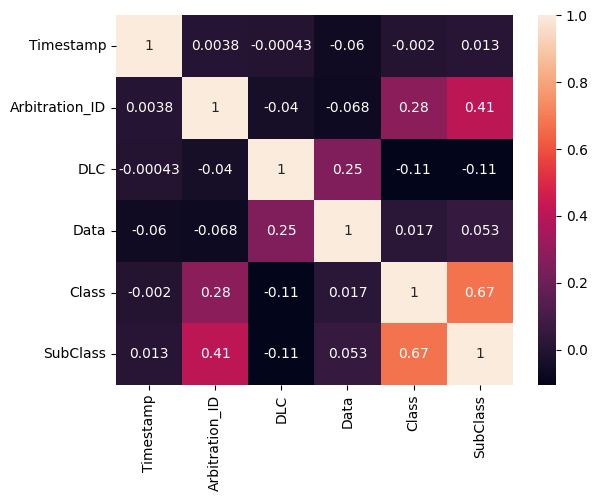

In [ ]:
sns.heatmap(train_df.corr(),annot=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3312119 entries, 0 to 889394
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       float64
 1   Arbitration_ID  float64
 2   DLC             int64  
 3   Data            float64
 4   Class           int64  
 5   SubClass        int64  
dtypes: float64(3), int64(3)
memory usage: 176.9 MB


In [ ]:
min_timestamp = train_df['Timestamp'].min()
train_df['Timestamp'] = train_df['Timestamp'] - min_timestamp
test_df['Timestamp'] = test_df['Timestamp'] - min_timestamp
val_df['Timestamp'] = val_df['Timestamp'] - min_timestamp

In [ ]:
train_df.head()

,Timestamp,Arbitration_ID,DLC,Data,Class,SubClass
0,0.000000,0.424453,8,2.982233e-08,1,2
1,0.000235,0.432406,7,7.616305e-04,1,2
2,0.000463,0.432903,8,2.734466e-15,1,2
3,0.000700,0.433400,8,8.101610e-13,1,2
4,0.000932,0.302187,8,2.027906e-02,1,2


In [ ]:
x_train = train_df.drop(['Class', 'SubClass'], axis=1)
y_train = train_df[['Class', 'SubClass']]

x_test = test_df.drop(['Class', 'SubClass'], axis=1)
y_test = test_df[['Class', 'SubClass']]

x_val = val_df.drop(['Class', 'SubClass'], axis=1)
y_val = val_df[['Class', 'SubClass']]

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
x_train_cnn = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_validate_cnn = x_validate.values.reshape(x_validate.shape[0], x_validate.shape[1], 1)
x_test_cnn = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val_cnn = x_val.values.reshape(x_val.shape[0], x_val.shape[1], 1)

In [ ]:
# CNN-LSTM Model

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same', input_shape=(x_train_cnn.shape[1], 1)))
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same'))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
learning_rate_reduction = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
batch_size = 64
epochs = 10
small_steps_per_epoch = 400
history = model.fit(x_train_cnn, y_train, batch_size=batch_size,
                    steps_per_epoch=small_steps_per_epoch,
                    epochs=epochs,
                    validation_data=(x_validate_cnn, y_validate),
                    callbacks=[learning_rate_reduction, checkpoint])

Epoch 1/10
398/400 [============================>.] - ETA: 0s - loss: 65.1762 - accuracy: 0.9514
Epoch 1: val_loss improved from 71.83694 to 55.72370, saving model to best_model.h5
400/400 [==============================] - 27s 67ms/step - loss: 65.1187 - accuracy: 0.9514 - val_loss: 55.7237 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 2/10
397/400 [============================>.] - ETA: 0s - loss: 48.1270 - accuracy: 0.9536
Epoch 2: val_loss improved from 55.72370 to 36.44864, saving model to best_model.h5
400/400 [==============================] - 26s 66ms/step - loss: 48.0227 - accuracy: 0.9537 - val_loss: 36.4486 - val_accuracy: 0.9538 - lr: 9.0000e-04
Epoch 3/10
399/400 [============================>.] - ETA: 0s - loss: 28.0222 - accuracy: 0.9529
Epoch 3: val_loss improved from 36.44864 to 16.07760, saving model to best_model.h5
400/400 [==============================] - 27s 67ms/step - loss: 27.9897 - accuracy: 0.9530 - val_loss: 16.0776 - val_accuracy: 0.9538 - lr: 8.1000e-04
Epoch

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_cnn, y_test, batch_size=batch_size)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

58626/58626 [==============================] - 272s 5ms/step - loss: 11.9719 - accuracy: 0.9489
Test Loss: 11.971887588500977
Test Accuracy: 0.9489134550094604


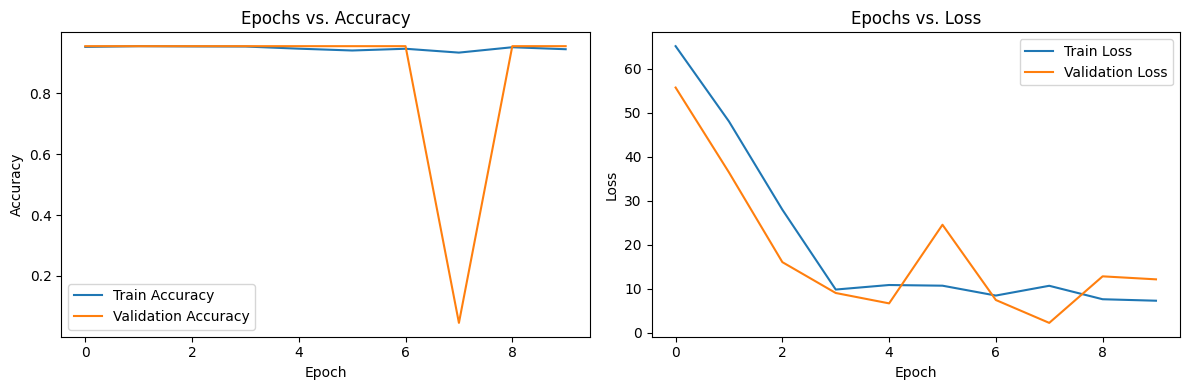

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epochs vs. Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/custom_project/model/'
model_filename = 'cnn_lstm_model.h5'
model.save(os.path.join(model_save_path, model_filename))

In [ ]:
from tensorflow.keras.models import load_model

model_save_path = '/content/drive/My Drive/Colab Notebooks/custom_project/model/'
model_filename = 'cnn_lstm_model.h5'
loaded_model = load_model(os.path.join(model_save_path, model_filename))

In [ ]:
import random

num_samples = 5
random_indices = random.sample(range(len(val_df)), num_samples)

random_samples = x_test_cnn[random_indices]
random_labels = val_df.iloc[random_indices]['SubClass']

predictions = loaded_model.predict(random_samples)

1/1 [==============================] - 0s 22ms/step


In [ ]:
for i in range(num_samples):
    actual_label = random_labels.iloc[i]
    predicted_label = np.argmax(predictions[i])
    print(f"Sample {i+1}: Actual={actual_label}, Predicted={predicted_label}")

Sample 1: Actual=1, Predicted=1
Sample 2: Actual=1, Predicted=1
Sample 3: Actual=1, Predicted=1
Sample 4: Actual=1, Predicted=1
Sample 5: Actual=1, Predicted=1
